In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from Models import probitModel, logisticModel
from util import *
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import *
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import *
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from joblib import Memory
from shutil import rmtree

from sklearn.metrics import get_scorer

In [2]:
SEED = 1

data_folder = 'data'
df = pd.read_csv(os.path.join(data_folder,'mimiciv_traindata.csv'))
df.head()

,Fraction inspired oxygen_mean,Fraction inspired oxygen_min,Fraction inspired oxygen_max,Glucose_mean,Glucose_min,Glucose_max,Heart Rate_mean,Heart Rate_min,Heart Rate_max,Mean blood pressure_mean,...,Temperature_mean,Temperature_min,Temperature_max,Weight_mean,Weight_min,Weight_max,pH_mean,pH_min,pH_max,mortality
0,0.484615,0.4,0.6,155.181818,52.0,280.0,52.367347,35.0,93.0,87.096154,...,36.356349,35.200000,37.100000,81.419764,81.419764,81.419764,7.328750,7.19,7.40,1.0
1,0.600000,0.5,1.0,127.954545,85.0,177.0,72.660377,58.0,105.0,72.315789,...,36.786325,36.388889,37.055556,93.103510,91.807021,95.000000,7.377143,7.34,7.42,0.0
2,0.481250,0.4,0.8,145.625000,116.0,180.0,107.260000,96.0,118.0,86.462963,...,37.316239,36.611111,37.944444,67.500000,67.500000,67.500000,7.372000,7.29,7.45,0.0
3,0.400000,0.4,0.4,100.142857,77.0,154.0,57.250000,47.0,65.0,69.762712,...,NaN,NaN,NaN,80.403091,76.838485,86.000000,7.161250,6.00,7.36,1.0
4,0.566667,0.4,1.0,138.000000,116.0,155.0,84.015625,64.0,114.0,70.662162,...,36.148990,34.722222,37.666667,NaN,NaN,NaN,7.374444,7.27,7.42,1.0


In [3]:
x = df.drop('mortality',axis=1)
y = df.mortality.values


mortality
0.0    0.749424
1.0    0.250576
Name: proportion, dtype: float64


<Axes: xlabel='mortality'>

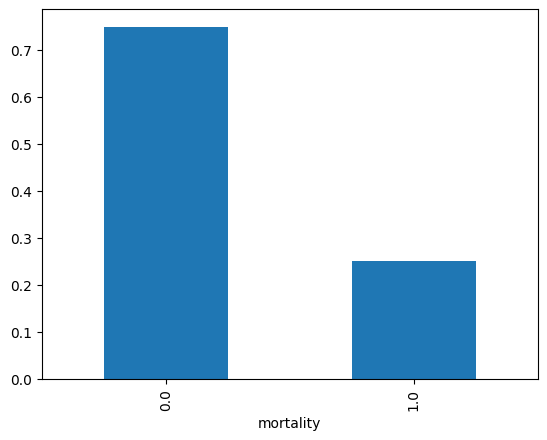

In [4]:
print(df.mortality.value_counts(normalize=True))
df.mortality.value_counts(normalize=True).plot(kind='bar')
#sns.countplot(x='mortality', data=df)

# GridSearchCV for weight of weighted loss

### Probit

In [5]:
probit_pipeline = [
    #('scaler', RobustScaler(unit_variance=True)),
    #('scaler', QuantileTransformer(output_distribution='normal', ignore_implicit_zeros=False)),
    ('scaler', PowerTransformer(method='yeo-johnson', standardize=True)),
    #('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('imputer', KNNImputer(missing_values=np.nan, n_neighbors=10)),
   # ('smote', SMOTE(random_state = SEED)),
    ('model',probitModel()),
]

In [ ]:
pipe = Pipeline(probit_pipeline)
param_grid = {
    'model__w': np.arange(0.1,1.0,0.05),
}
search = GridSearchCV(pipe, param_grid, cv=5, scoring=make_scorer(f1_score), n_jobs=-1, verbose=3)
search.fit(x,y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [ ]:
search.best_params_

### Logistic Model

In [ ]:
logistic_pipeline = [
    #('scaler', RobustScaler(unit_variance=True)),
    #('scaler', QuantileTransformer(output_distribution='normal', ignore_implicit_zeros=False)),
    ('scaler', PowerTransformer(method='yeo-johnson', standardize=True)),
    #('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('imputer', KNNImputer(missing_values=np.nan, n_neighbors=10)),
   # ('smote', SMOTE(random_state = SEED)),
    ('model', logisticModel()),
]

In [ ]:
pipe = Pipeline(probit_pipeline)
param_grid = {
    'model__w': np.arange(0.1,1.0,0.05),
}
search = GridSearchCV(pipe, param_grid, cv=5, scoring=make_scorer(f1_score), n_jobs=-1, verbose=3)
search.fit(x,y)

In [ ]:
search.best_params_

# Bayes Opt

In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
def probit_cv(l1, l2):
    probit_pipeline = [
        #('scaler', RobustScaler(unit_variance=True)),
        #('scaler', QuantileTransformer(output_distribution='normal', ignore_implicit_zeros=False)),
        ('scaler', PowerTransformer(method='yeo-johnson', standardize=True)),
        #('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('imputer', KNNImputer(missing_values=np.nan, n_neighbors=10)),
    # ('smote', SMOTE(random_state = SEED)),
        ('model',probitModel( l1=l1, l2=l2, w=0.75 )),
    ]


    mean_score = cv(probit_pipeline, x.values, y, f1_score, 5, random_state=SEED)

    return mean_score

In [ ]:
xgb_bo = BayesianOptimization(
    probit_cv, 
    pbounds={
        'l1':(0,5),
        'l2':(0,5),
    },                              
    verbose=2
)

In [ ]:
from datetime import datetime

start = datetime.now()

xgb_bo.maximize(init_points=3, n_iter=100)

time_elapsed = datetime.now() - start

print('Time elapsed:',time_elapsed)